# Introduction
This Notebook contains my work for analyzing a 100km transect in the Southern Ocean. The goal is to identify Lee waves from the measurements and then estimate the energy fluxes and transport driven by these lee waves. For some of the more standard plots such as transect contours, I also experiment with my Ocean Toolbox package



In [1]:
# Load Data and relevant modules
%matplotlib inline
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import data_load
import gsw
import oceans as oc
import pandas as pd
import internal_waves_calculations as iwc


ladcp, ctd = data_load.load_data()
wl_max=1200
wl_min=400
ctd_bin_size=1500
ladcp_bin_size=1500

# Extracting Wave Components
This section uses spectral analysis to estimate kinetic and potential energies lee waves. Using a minimum and maximum vertical wavelength as integration limits, I estimate the energetics of target wavelengths. These limits were determined qualitatively by estimative vertical size of features in profiles (how big are the wiggles). 

## Internal Energy
The wave components are estimated through calcuation of the internal wave energy components (Kinetic and Potential). To do this, each profile is seperated into mean and wave-induced perturbations $(X = X + X')$. In order to do this a sliding vertical polynomial is fit to each profile and the resultant profile is subtracted out, leaving the perturbation profile.

### Kinetic Energy
The resultant velocity perturbation profiles (u and v) are binned into 1024 meter, half overlapping bins. The Power Spectral Density is calculated along each being and integrated between a target wavelength band. This band is chosen by examining the perturbation profiles and identifying coherent wave features. The final values are input into the kinetic energy equation. $\langle \rangle$ denotes integrated power spectral density. 

$$ KE = \frac{1}{2}\big[ \langle u'^{2} \rangle + \langle v'^{2} \rangle \big] $$

### Potential Energy 
A similar process is followed for estimating potential energy. However, 2 methods were implemented here, with varying results. The first was to estimate the isopycnal displacement $\eta$ from density perturbations as follows: 

$$\eta = \frac{\rho - \rho_{ref}}{\frac{\Delta \rho_{ref}}{\Delta z}}$$
            
$\rho_{ref}$ is estimated as a transect mean density profile. However, this showed erratic and unrealistic values most likely stemming from how $\frac{d\rho_{ref}}{dz}$ was estimated. The second method utlized the relationship of strain $\xi$ as the vertical gradient of $\eta$. Strain was calculated as

$$ \xi = \frac{N^{2} - {N_{ref}}^2}{{N_{ref}}^2}$$

where $N^2$ is estimated using the adiabtic leveling method derived by Bray and Foffonof(insert year). $N_{ref}^2$ is estimated as the mean N2 profile of the transect. $\xi$ is multipled by the vertical grid spacing of the data, an estimate of $\Delta z$ to obtain $\eta$:

$$ \eta = \xi * \Delta z $$

Once $\eta$ is obtained, the same processes for calculating Power Spectral Density used in kinetic energy calculations are used here with the potential energy equation:

$$ PE = \frac{1}{2}N^2\langle \eta'^{2} \rangle $$

The energy components are combined for the total internal energy $(\frac{J}{m^s})$:

$$ E = \rho(KE + PE) $$

Using the two energy components, the internal wave frequencies are estimated by:

$$ \omega_{0} = f\sqrt{\frac{KE + PE}{KE - PE}}$$

Several other derivations are used and compared with similar results. An issue with this method is that when kinetic and potential energies are similar, error in energy density calculations may cause kinetic energy to be slightly less than potential, resulting in a null value from the square root operation. 
We now have the intrinsic frequency as well as the vertical waveumnber $m$ which is estimated as the mean of integration limits. From here, $k_{h}$, the horizontal wave number is calculated from:

$$  k_{h} = m\sqrt{\frac{f^2 - \omega^2}{\omega^2 - N^2}}$$

### Decomposing the horizontal wave vector
TBD

# Run Functions on data loaded in.

In [2]:
U, V, p_ladcp = oc.loadLADCP(ladcp)
S, T, p_ctd, lat, lon = oc.loadCTD(ctd)
strain = np.genfromtxt('strain.csv', delimiter=',')
SA = gsw.SA_from_SP(S, p_ctd, lon, lat)
CT = gsw.CT_from_t(SA, T, p_ctd)
N2, dump = gsw.stability.Nsquared(SA, CT, p_ctd, lat)

maxDepth = 4000
idx_ladcp = p_ladcp[:, -1] <= maxDepth
idx_ctd = p_ctd[:, -1] <= maxDepth

strain = strain[idx_ctd, :]
S = S[idx_ctd,:]
p_ctd = p_ctd[idx_ctd, :]
U = U[idx_ladcp, :]
V = V[idx_ladcp, :]
p_ladcp = p_ladcp[idx_ladcp, :]
# Bin CTD data
ctd_bins = oc.binData(S, p_ctd[:, 0], ctd_bin_size)
# Bin Ladcp Data
ladcp_bins = oc.binData(U, p_ladcp[:, 0], ladcp_bin_size)

# Depth and lat/long grids
depths = np.vstack([np.nanmean(p_ctd[binIn]) for binIn in ctd_bins])
dist = gsw.distance(lon, lat)
dist = np.cumsum(dist)/1000
dist = np.append(0,dist)


# Calculate Potential Energy
z = -1*gsw.z_from_p(p_ctd, lat)
PE, PE_grid, eta_psd, N2mean = iwc.PE_strain(N2, z, strain,\
                                         wl_min, wl_max, ctd_bins)

# Calculate Kinetic Energy
z = -1*gsw.z_from_p(p_ladcp, lat)
KE, KE_grid, KE_psd, Uprime, Vprime = iwc.KE_UV(U, V, z, ladcp_bins,
                            wl_min, wl_max, lc=wl_min-50, detrend=False)

# Total Kinetic Energy
Etotal = (KE + PE) # Multiply by density to get Joules

/Users/manishdevana/saltyPhysics/Lee_waves_dissertation/internal_waves_calculations.py:184: RuntimeWarning: Mean of empty slice
  N2ref = np.nanmean(N2, axis=1)


In [3]:
# wave components
f = np.nanmean(gsw.f(lat))

# version 2 omega calculation
omega = f*np.sqrt(((KE+PE)/(KE-PE)))



# version 2 omega calculation
omega2 = ((f**2)*((KE+PE)/(KE-PE)))
rw = KE/PE
w0 = ((f**2)*((rw+1)/(rw-1)))
m = (2*np.pi)/np.mean((wl_min, wl_max))

# version 1 kh calculation
kh = m*np.sqrt(((f**2 - omega**2)/(omega**2 - N2mean)))

# version 2 kh calculation
khi = (m/np.sqrt(N2mean))*(np.sqrt(omega2 - f**2))
mask = kh == 0
kh[mask]= np.nan
lambdaH = 1e-3*(2*np.pi)/kh








/Users/manishdevana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/Users/manishdevana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


### Plotting velocity anomalies (version 1)


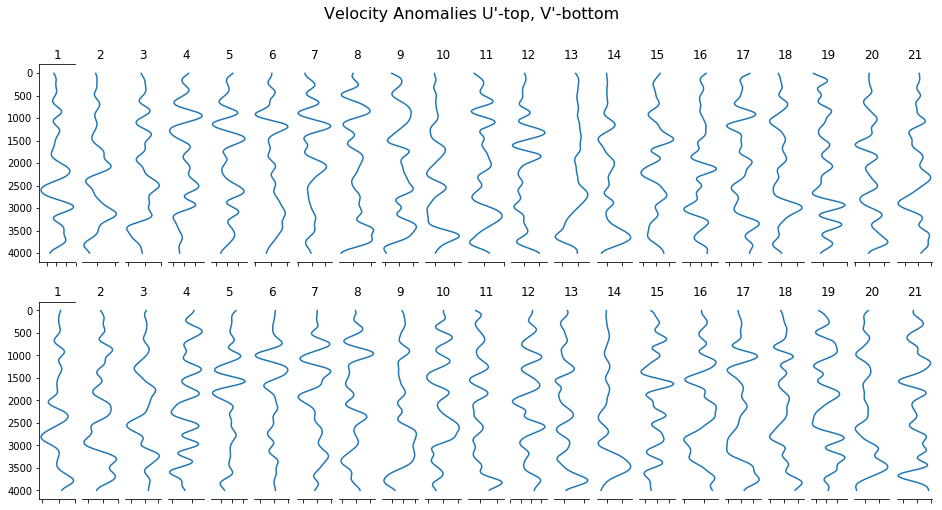

In [4]:
plt.figure(figsize=[16,8])

for i in range(lambdaH.shape[1]):
    
    if i == 0:
        plt.subplot(2,U.shape[1],i+1)
        plt.plot(Uprime[:,i], p_ladcp)
        plt.title(str(i+1))
        ax = plt.gca()
        plt.gca().invert_yaxis()
        ax.spines['right'].set_color(None)
        plt.setp( ax.get_xticklabels(), visible=False)
    else:
        plt.subplot(2,U.shape[1],i+1)
        plt.plot(Uprime[:,i], p_ladcp)
        ax = plt.gca()
        plt.title(str(i+1))
        plt.gca().invert_yaxis()
        ax.spines['bottom'].set_color('black')
        ax.spines['top'].set_color(None) 
        ax.spines['right'].set_color(None)
        ax.spines['left'].set_color(None)
        ax.get_yaxis().set_visible(False)
        plt.setp( ax.get_xticklabels(), visible=False)


for i in range(lambdaH.shape[1]):
    if i == 0:
        plt.subplot(2,U.shape[1],(i+1)+U.shape[1])
        plt.plot(Vprime[:,i], p_ladcp)
        plt.title(str(i+1))
        ax = plt.gca()
        plt.gca().invert_yaxis()

        ax.spines['right'].set_color(None)
        plt.setp( ax.get_xticklabels(), visible=False)
    else:
        plt.subplot(2,U.shape[1],(i+1)+U.shape[1])
        plt.plot(Vprime[:,i], p_ladcp)
        ax = plt.gca()
        plt.title(str(i+1))
        plt.gca().invert_yaxis()

        ax.spines['bottom'].set_color('black')
        ax.spines['top'].set_color(None) 
        ax.spines['right'].set_color(None)
        ax.spines['left'].set_color(None)
        ax.get_yaxis().set_visible(False)
        plt.setp( ax.get_xticklabels(), visible=False)
        
    plt.suptitle("Velocity Anomalies U'-top, V'-bottom", fontsize=16)
#     plt.savefig('velocity_anomalies.png', bbox_inches='tight')



,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1500.0,NaN,17.021085,45.562519,34.892195,28.794962,13.991978,53.824588,13.41403,16.097966,3.583369,...,45.054321,12.731903,15.355516,10.066197,NaN,9.218114,16.871513,NaN,8.483478,6.651274
2250.0,27.678053,34.937084,60.667192,6.401534,20.880837,3.327607,NaN,NaN,NaN,NaN,...,NaN,5.227337,5.161777,NaN,NaN,NaN,NaN,NaN,NaN,29.594306
3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1500.0,NaN,0.000369,0.000138,0.000180,0.000218,0.000449,0.000117,0.000468,0.00039,0.001753,...,0.000139,0.000493,0.000409,0.000624,NaN,0.000682,0.000372,NaN,0.000741,0.000945
2250.0,0.000227,0.000180,0.000104,0.000982,0.000301,0.001888,NaN,NaN,NaN,NaN,...,NaN,0.001202,0.001217,NaN,NaN,NaN,NaN,NaN,NaN,0.000212
3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/Users/manishdevana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1500.0,NaN,0.000146,0.000121,0.000124,0.000127,0.000151,0.000119,0.000151,0.000141,0.000352,...,0.00012,0.000148,0.000137,0.000156,NaN,0.000159,0.000131,NaN,0.000162,0.000186
2250.0,0.000124,0.000121,0.000118,0.000192,0.000125,0.000299,NaN,NaN,NaN,NaN,...,NaN,0.000203,0.000202,NaN,NaN,NaN,NaN,NaN,NaN,0.000120
3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1500.0,0.281783,0.434763,0.123726,0.277738,0.461710,0.299209,0.655019,0.15344,0.190673,0.286802,...,0.308961,0.077065,1.258749,0.913143,0.227532,0.076268,0.088431,0.131844,0.701233,0.361574
2250.0,2.110514,1.745413,0.262740,0.098449,0.144598,0.027243,NaN,NaN,NaN,NaN,...,0.273750,0.222853,0.307749,NaN,NaN,NaN,NaN,NaN,NaN,0.402457
3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1500.0,NaN,-0.000146,-0.000121,-0.000124,-0.000127,-0.000151,-0.000119,-0.000151,-0.000141,-0.000352,...,-0.00012,-0.000148,-0.000137,-0.000156,NaN,-0.000159,-0.000131,NaN,-0.000162,-0.000186
2250.0,-0.000124,-0.000121,-0.000118,-0.000192,-0.000125,-0.000299,NaN,NaN,NaN,NaN,...,NaN,-0.000203,-0.000202,NaN,NaN,NaN,NaN,NaN,NaN,-0.000120
3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1500.0,NaN,0.000368,0.000138,0.00018,0.000218,0.000447,0.000116,0.000466,0.000389,0.001706,...,0.000139,0.000491,0.000407,0.00062,NaN,0.000676,0.00037,NaN,0.000734,0.000934
2250.0,0.000226,0.000179,0.000103,0.00097,0.000299,0.001827,NaN,NaN,NaN,NaN,...,NaN,0.001181,0.001196,NaN,NaN,NaN,NaN,NaN,NaN,0.000211
3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


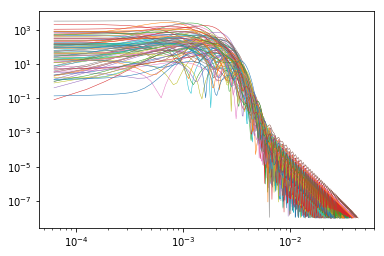

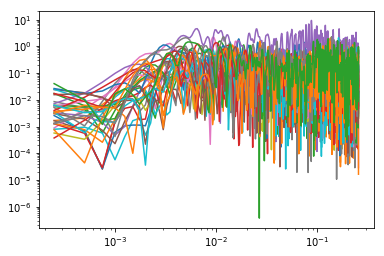

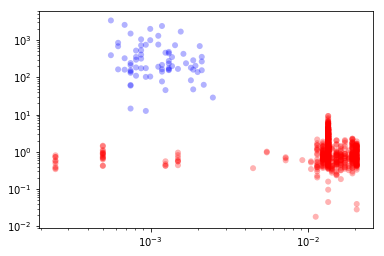

In [6]:
plt.figure()

plt.loglog(KE_grid, KE_psd.T, linewidth=.5)
plt.figure()
plt.loglog(PE_grid, .5*np.nanmean(N2)*eta_psd.T)

plt.figure()
Kemax = np.nanmax(KE_psd, axis=1)
kespots = np.nanargmax(KE_psd, axis=1)
ax = plt.gca()
ax.scatter(KE_grid[kespots],Kemax , c='blue', alpha=0.3, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')


Kemax = np.nanmax(.5*np.nanmean(N2)*eta_psd.T, axis=1)
kespots = np.nanargmax(.5*np.nanmean(N2)*eta_psd.T, axis=1)
ax = plt.gca()
ax.scatter(PE_grid[kespots],Kemax , c='red', alpha=0.3, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')
plt.figure(figsize=[16,8])

